In [1]:
import astropy
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astroplan.plots import plot_airmass
from astroplan import Observer, FixedTarget, AirmassConstraint, AtNightConstraint
from astroplan import is_observable
import astropy.units as u
from tqdm import tqdm

np.random.seed(42)

In [2]:
observer = Observer.at_site('lapalma')
coordinates = SkyCoord('00h00m00.0s', '+45d00m00.0s', frame='icrs')
target = FixedTarget(name='target star', coord=coordinates)

In [3]:
survey_start = Time('2021-03-01 12:00:00')
survey_dates = []

In [4]:
constraints = [AirmassConstraint(1.5), AtNightConstraint.twilight_nautical()]
for n in tqdm(range(365)):
    if is_observable(constraints, observer, target, 
                         time_range=[survey_start+n*TimeDelta(1.*u.day), 
                                     survey_start+(n+1)*TimeDelta(1.*u.day)]):
        survey_dates.append(survey_start+n*TimeDelta(1.*u.day))

100%|██████████| 365/365 [00:27<00:00, 13.22it/s]


In [5]:
len(survey_dates)

256

In [7]:
t_zeniths = np.zeros(len(survey_dates)) + np.nan
t_zeniths_type = []
t_randomized = np.zeros(len(survey_dates)) + np.nan

dark_horizon = 12. * u.deg # horizon for sunset/sunrise crossing

for i,t in tqdm(enumerate(survey_dates)):
    t_rise = observer.target_rise_time(t, target, which='nearest', horizon=30.*u.deg)
    t_set = observer.target_set_time(t_rise, target, which='next', horizon=30.*u.deg)
    t_zenith = t_rise + (t_set - t_rise)/2.
    if observer.is_night(t_zenith, horizon=dark_horizon):
        t_zeniths[i] = t_zenith.jd
        t_zeniths_type.append('zenith')
    elif observer.is_night(t_rise, horizon=dark_horizon):
        t_zeniths[i] = observer.sun_rise_time(t_rise, horizon=dark_horizon, which='next').jd
        t_zeniths_type.append('end of night')
    else:
        t_zeniths[i] = observer.sun_set_time(t_rise, horizon=dark_horizon, which='next').jd 
        t_zeniths_type.append('start of night')

    # the following is slow but idk how to be more clever in astroplan:
    for j in range(100):
        t_random = t_zenith + (np.random.random() * 16. - 8.) * TimeDelta(1.*u.hour) # perturb by 8 hours in either direction
        if is_observable(constraints, observer, target, times=t_random):
            t_randomized[i] = t_random.jd
            break


256it [01:49,  2.34it/s]


start of night


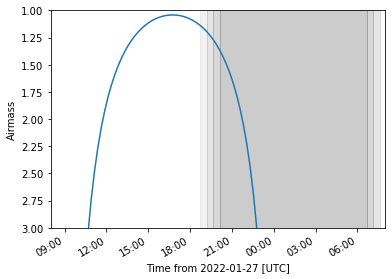

In [8]:
plot_airmass(target, observer, survey_dates[-10]+TimeDelta(8.*u.hour), 
             brightness_shading=True)
print(t_zeniths_type[-10])

In [9]:
t_rise = observer.target_rise_time(survey_dates[-10], target, which='nearest', horizon=30.*u.deg)
t_rise.datetime
observer.is_night(t_rise, horizon=-12.*u.deg)
sunset = observer.sun_set_time(t_rise, horizon=dark_horizon, which='next')
observer.altaz(Time(sunset, format='jd'), target).secz.value

1.063522362203491

#### to check: is the secz() approximation a bad one here?
is that why the airmass seems inconsistent from the plot?

In [10]:
airmasses_zenith = np.zeros_like(t_zeniths)
for i,tz in enumerate(t_zeniths):
    try:
        airmasses_zenith[i] = observer.altaz(Time(tz, format='jd'), target).secz.value
    except ValueError:
        continue

In [11]:
airmasses_random = np.zeros_like(t_randomized)
for i,tr in enumerate(t_randomized):
    try:
        airmasses_random[i] = observer.altaz(Time(tr, format='jd'), target).secz.value
    except ValueError:
        continue

In [12]:
np.sum(np.isfinite(t_randomized))

254

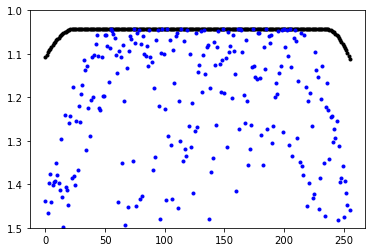

In [13]:
plt.plot(airmasses_zenith, 'k.')
plt.plot(airmasses_random, 'b.')
plt.ylim([1.5,1.0]);

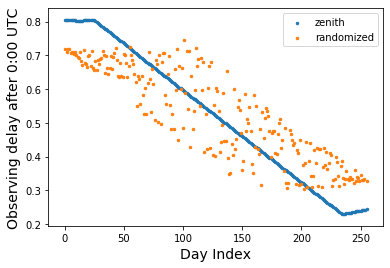

In [15]:
day_inds = np.arange(len(t_zeniths))
plt.scatter(day_inds, t_zeniths % 1.0, label='zenith', s=6)
plt.scatter(day_inds, t_randomized % 1.0, label='randomized', s=6)
plt.xlabel('Day Index', fontsize=14)
plt.ylabel('Observing delay after 0:00 UTC', fontsize=14)
plt.legend();
#plt.plot(day_inds, sunrises, label='sunrise')
#plt.plot(day_inds, sunsets, label='sunset')

In [16]:
t_obs_zenith = t_zeniths[np.isfinite(t_zeniths)]
t_obs_zenith += np.random.normal(0., 30./60./24., len(t_obs_zenith)) # 30-minute perturbation

In [17]:
airmasses = [observer.altaz(Time(to, format='jd'), target).secz.value for to in t_obs_zenith]

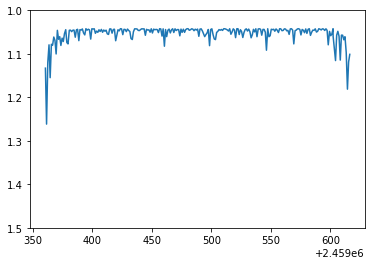

In [42]:
plt.plot(t_obs_zenith,airmasses)
plt.ylim([1.5,1.0]);

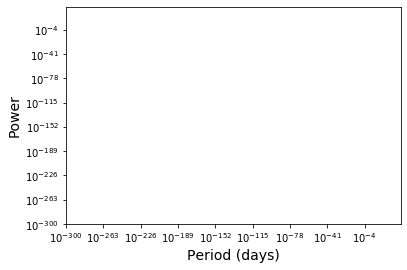

In [90]:
ys_zenith = np.ones_like(t_obs_zenith)/len(t_obs_zenith)# + np.random.normal(0., 1.e-19, len(t_obs_zenith))
frequency, power_zenith = LombScargle(t_obs_zenith - t_obs_zenith[0], 
                                      ys_zenith).autopower(minimum_frequency=0.01,
                                                   maximum_frequency=5.,
                                                   samples_per_peak=5)
plt.loglog(1./frequency, power_zenith)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);

In [91]:
t_obs_randomized = t_randomized[np.isfinite(t_randomized)]
ys_randomized = np.ones_like(t_obs_randomized)/len(t_obs_randomized)

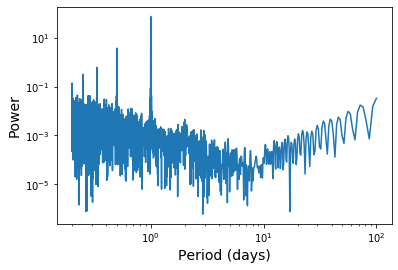

In [92]:
power_randomized = LombScargle(t_obs_randomized, 
                               ys_randomized).power(frequency)
plt.loglog(1./frequency, power_randomized)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);
#plt.axvline(0.33, color='C1', alpha=0.7, ls='--');

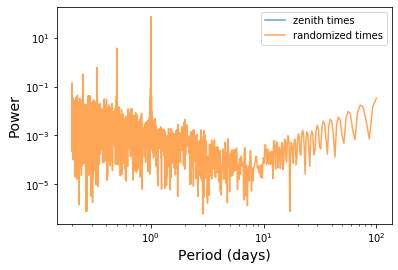

In [93]:
plt.loglog(1./frequency, power_zenith, alpha=0.7, label='zenith times')
plt.loglog(1./frequency, power_randomized, alpha=0.7, label='randomized times')
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14)
plt.legend();

In [94]:
len(t_obs_randomized)

254

In [95]:
len(t_obs_zenith)

256